# BTC-USD @24h

In [1]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
OUT_FILENAME = './results/btc24h_ohlc_dow.csv'
OUT_RETRAINED_FILENAME = './results/btc24h_ohlc_dow.ret.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


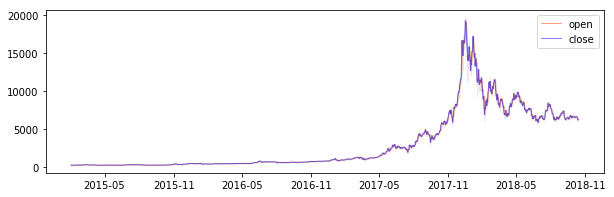

In [5]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [6]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs. More consistency at 10 but average quality drops.

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140342180243024
Tensor("lstm_1_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 820
Non-trainable params: 0
____________________________________________________________

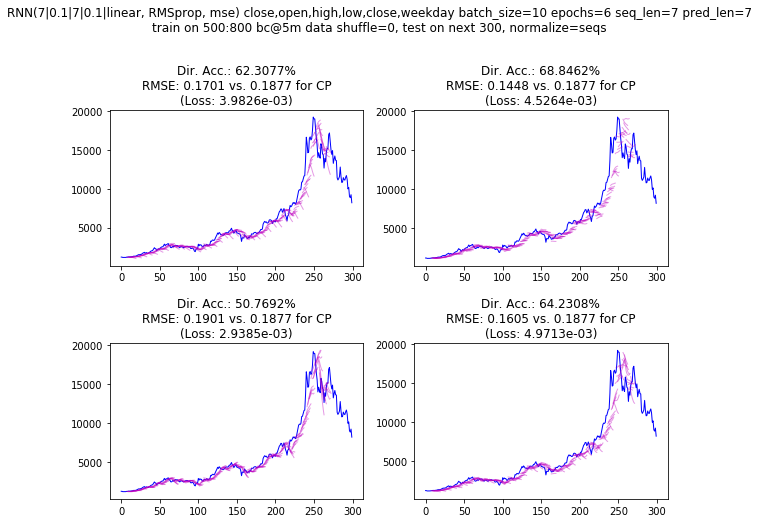

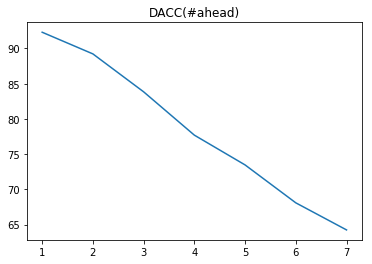

--- 34.118s to run experiment



In [9]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (1200, 6)
--- 0.016s to model compilation time


--- Created model id: 140342180086416
Tensor("lstm_9_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_10 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 820
Non-trainable params: 0
___________________________________________________________

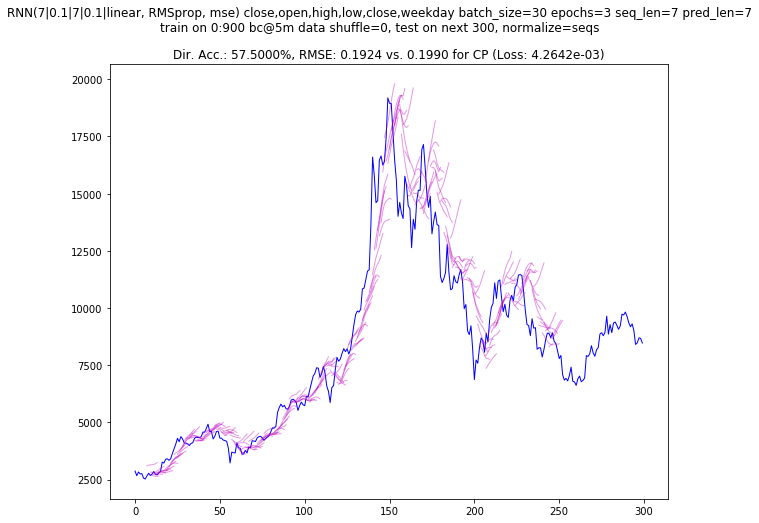

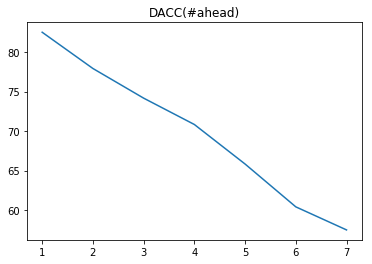

--- 6.787s to run experiment



In [10]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=900,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=3,
        batch_size=30,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140340100796880
Tensor("lstm_11_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_12 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 208
Trainable params: 208
Non-trainable params: 0
___________________________________________________________

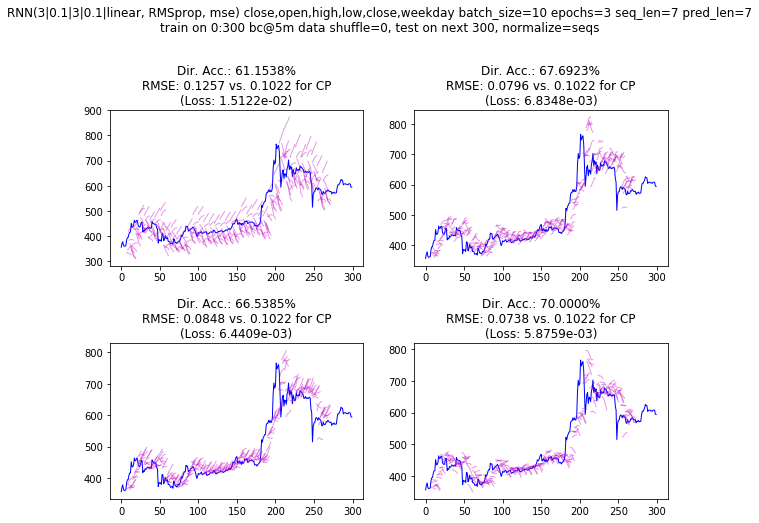

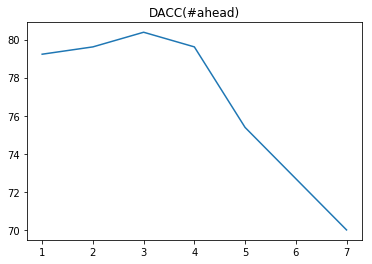

--- 30.561s to run experiment



In [11]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140338859413392
Tensor("lstm_75_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_75 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_76 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 208
Non-trainable params: 0
___________________________________________________________

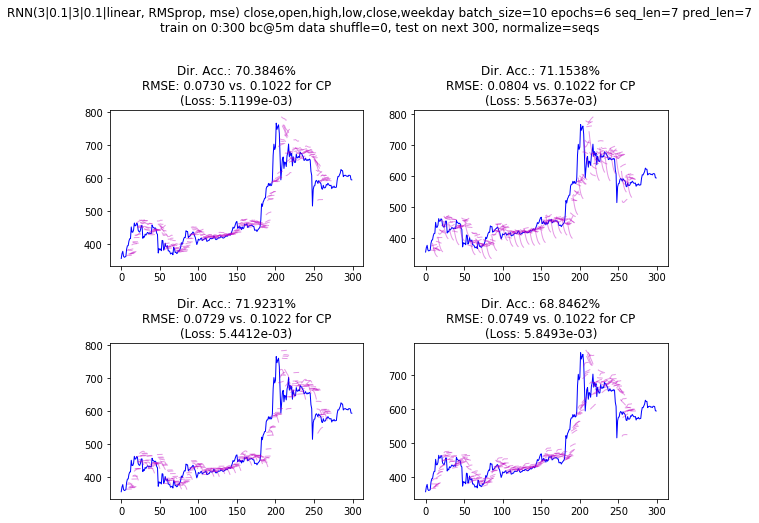

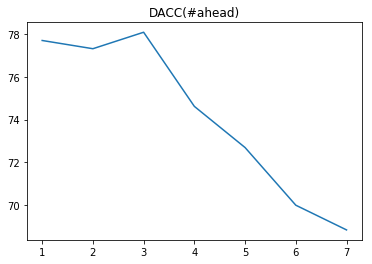

--- 65.067s to run experiment



In [19]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 14|0.1|14|0.1

**Conclusion:** Not better results than smaller networks?

data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140339402126160
Tensor("lstm_27_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 14)             1176      
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_28 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 15        
Total params: 2,815
Trainable params: 2,815
Non-trainable params: 0
_______________________________________________________

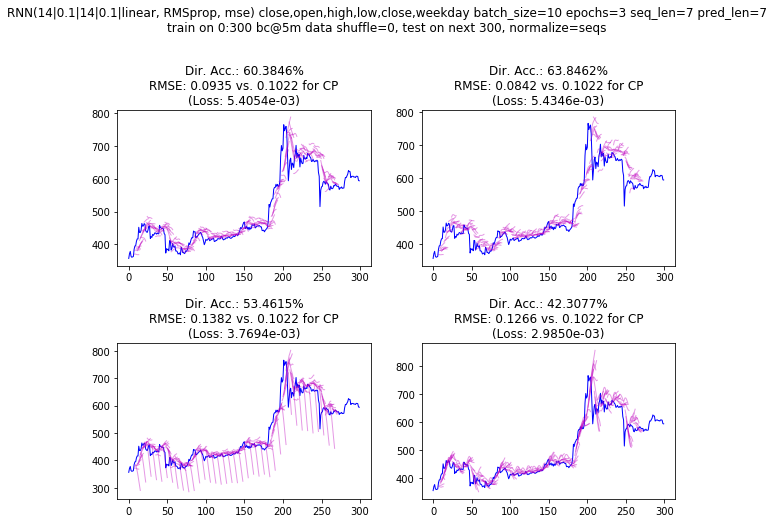

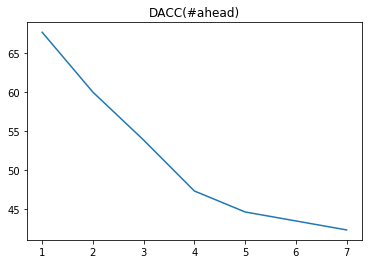

--- 37.206s to run experiment



In [13]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140339310281808
Tensor("lstm_35_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 7, 14)             1176      
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_36 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 15        
Total params: 2,815
Trainable params: 2,815
Non-trainable params: 0
_______________________________________________________

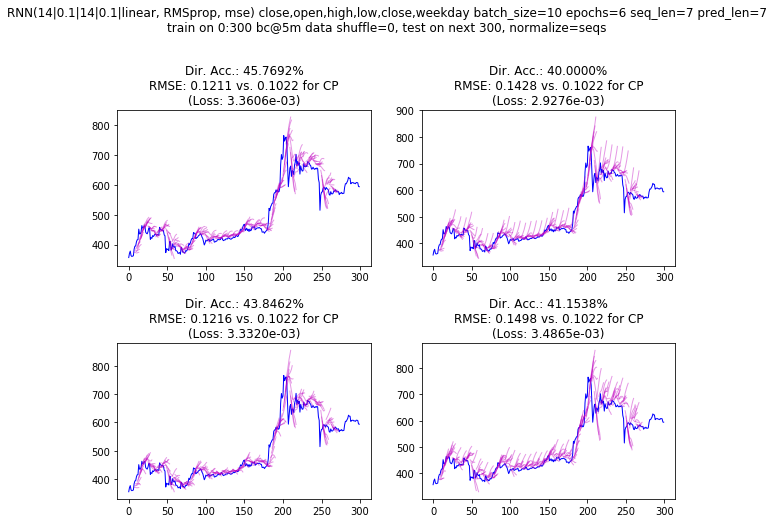

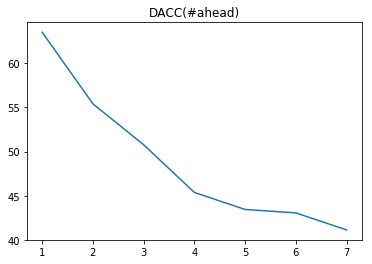

--- 48.259s to run experiment



In [14]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140339310657872
Tensor("lstm_43_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 7, 14)             1176      
_________________________________________________________________
dropout_43 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_44 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 15        
Total params: 2,815
Trainable params: 2,815
Non-trainable params: 0
_______________________________________________________

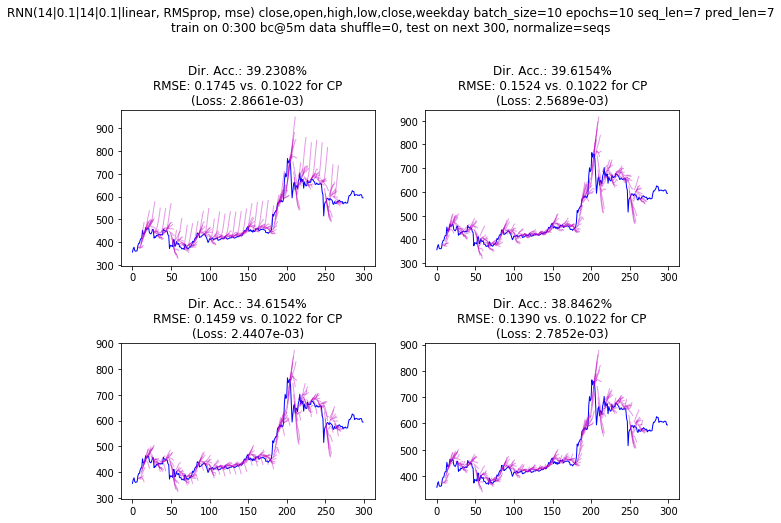

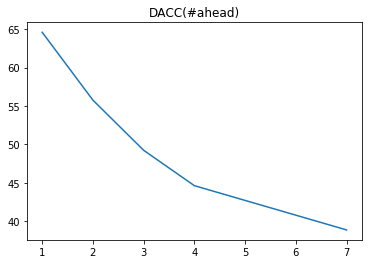

--- 61.845s to run experiment



In [15]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140339022398736
Tensor("lstm_59_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 7, 14)             1176      
_________________________________________________________________
dropout_59 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_60 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 15        
Total params: 2,815
Trainable params: 2,815
Non-trainable params: 0
_______________________________________________________

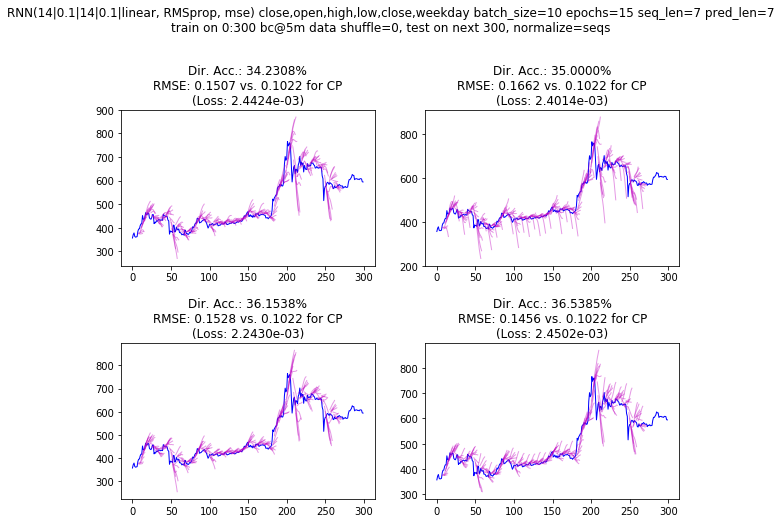

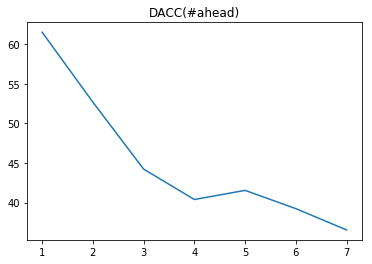

--- 81.806s to run experiment



In [17]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 30|0.1|30|0.1

**Conclusion:** Really bad results, best at 3-6 epochs but comparatively too bad to worth condiering this further.

data ~ (900, 6)
--- 0.016s to model compilation time


--- Created model id: 140338948418576
Tensor("lstm_67_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 7, 30)             4440      
_________________________________________________________________
dropout_67 (Dropout)         (None, 7, 30)             0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_68 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 31        
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
_____________________________________________________

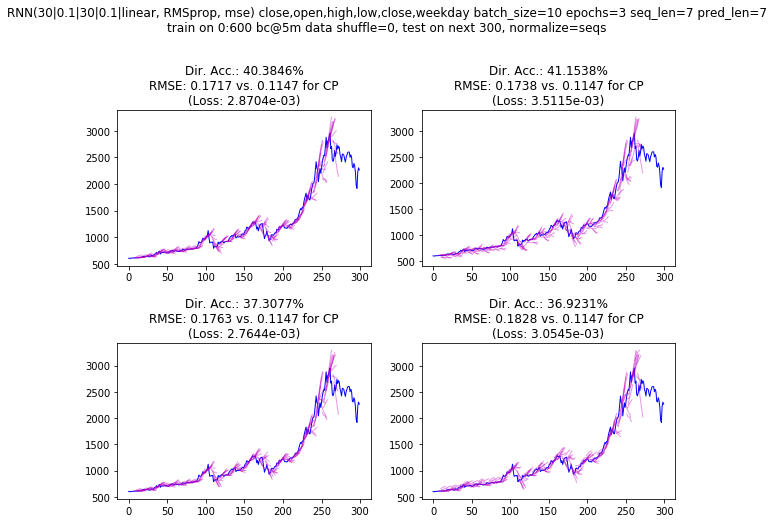

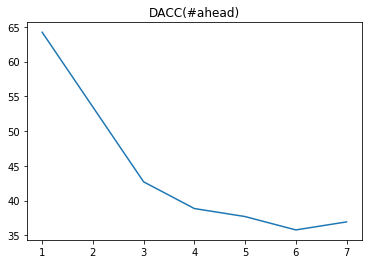

--- 62.998s to run experiment



In [18]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close', 'weekday'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([30, 0.1, 30, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

## Full runs

In [33]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data24h,
    'features': ['close', 'open', 'high', 'low', 'volume', 'weekday'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([3, 0.1, 3, 0.1]),
    # training:
    'epochs': 6,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [34]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [23]:
def full_run(idx_from, idx_to, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(OUT_FILENAME, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140338655782032
Tensor("lstm_93_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_93 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_94 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 208
Non-trainable params: 0
___

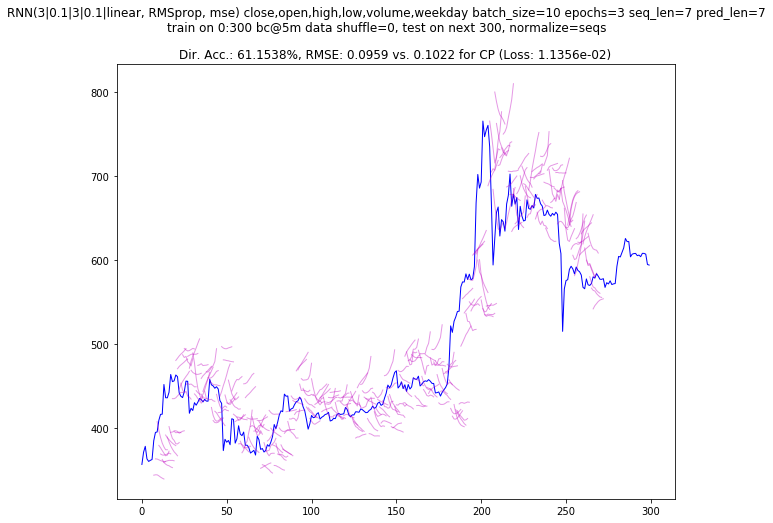

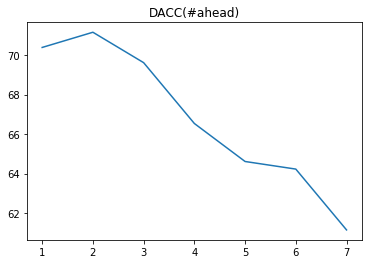

--- 16.205s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140338627926480
Tensor("lstm_95_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_95 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_96 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_96 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 2

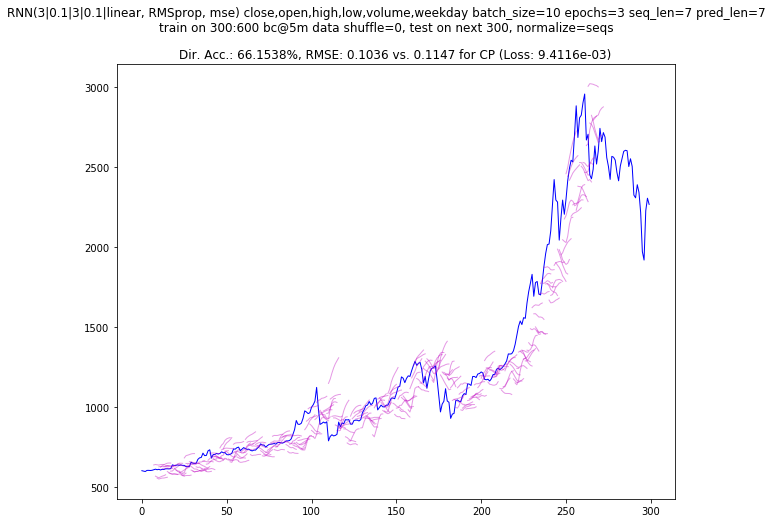

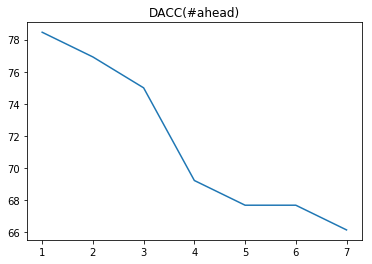

--- 16.464s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140338602366416
Tensor("lstm_97_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 7, 3)              120       
_________________________________________________________________
dropout_97 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_98 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 4         
Total params: 208
Trainable params: 2

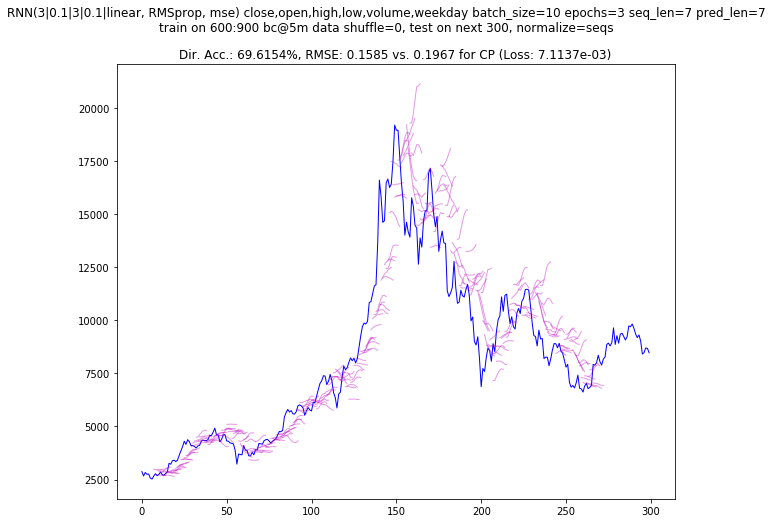

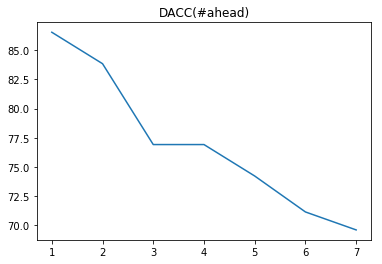

--- 16.616s to run segment

--- 49.286s to full run 300 - 1051



In [32]:
full_run(300, 1051, write_csv_header=True)

In [26]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close,op...",0,300,300,False,seqs,0.006270,0.0749%,0.1022%,73.0769%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close,op...",300,600,300,False,seqs,0.006800,0.0845%,0.1147%,76.9231%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close,op...",600,900,300,False,seqs,0.006898,0.1587%,0.1967%,68.8462%


In [29]:
(73.00 + 76.92 + 68.84) / 3

72.92

In [62]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",0,300,300,False,seqs,0.004466,0.0727%,0.1022%,70.0000%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",300,600,300,False,seqs,0.004734,0.0834%,0.1147%,79.6154%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",600,900,300,False,seqs,0.007003,0.1487%,0.1967%,77.3077%


In [30]:
(70.00 + 79.61 + 77.30) / 3

75.63666666666667